
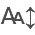

now working /home/ken/src/github.com/endaaman/bt


In [1]:
import os
import re
import sys

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider
from umap import UMAP
import ipynbname
from endaaman.ml import fix_global_seed
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)
fix_global_seed()

project_root = os.path.abspath(os.path.join(os.path.dirname(ipynbname.path()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)
print('now working', project_root)


sns.set_theme(style='ticks', palette='tab10')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'figure.dpi': 300,
})

os.makedirs('out/figs', exist_ok=True)

In [2]:
import random
import colorcet as cc

labels = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    r'ViT-L$\mathrm{_{IN}}$(FT)',
    r'ViT-L$\mathrm{_{IN}}$(LP)',
    r'ViT-L(RI)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
    r'ResNet-RS 50(RI)',
]
print(len(labels))
# colors = sns.color_palette('pastel20', len(label))
colors = sns.color_palette(cc.glasbey_hv, n_colors=len(labels))
color_map = dict(zip(labels, colors))
display(colors)

11


[(0.18824, 0.63529, 0.85490),
 (0.98823, 0.30980, 0.18824),
 (0.89804, 0.68235, 0.21961),
 (0.42745, 0.56471, 0.30980),
 (0.54510, 0.54510, 0.54510),
 (0.09020, 0.74510, 0.81176),
 (0.58039, 0.40392, 0.74118),
 (0.83922, 0.15294, 0.15686),
 (0.12157, 0.46667, 0.70588),
 (0.89020, 0.46667, 0.76078),
 (0.54902, 0.33726, 0.29412)]

In [3]:
labels = [
    r'Prov-GigaPath(LP)',
    r'UNI(FT)',
    r'UNI(LP)',
    r'CTransPath(FT)',
    r'CTransPath(LP)',
    r'ViT-L$\mathrm{_{IN}}$(FT)',
    r'ViT-L$\mathrm{_{IN}}$(LP)',
    r'ViT-L(RI)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',    
]


key_map = {
    'oacc': 'Overall Acc.',
    'pacc': 'Patch Acc.',
    'recall': 'Macro Recall',
    'prec': 'Macro Prec.',
    'acc': 'Macro Acc.',
    'f1': 'Macro F1',
    'grecall': 'G Recall',
    'arecall': 'A Recall',
    'orecall': 'O Recall',
    'mrecall': 'M Recall',
    'lrecall': 'L Recall',

    'gprec': 'G Prec.',
    'aprec': 'A Prec.',
    'oprec': 'O Prec.',
    'mprec': 'M Prec.',
    'lprec': 'L Prec.',
}

def is_patial_metric(k):
    l = list(key_map.keys())
    return l.index(k) > 5

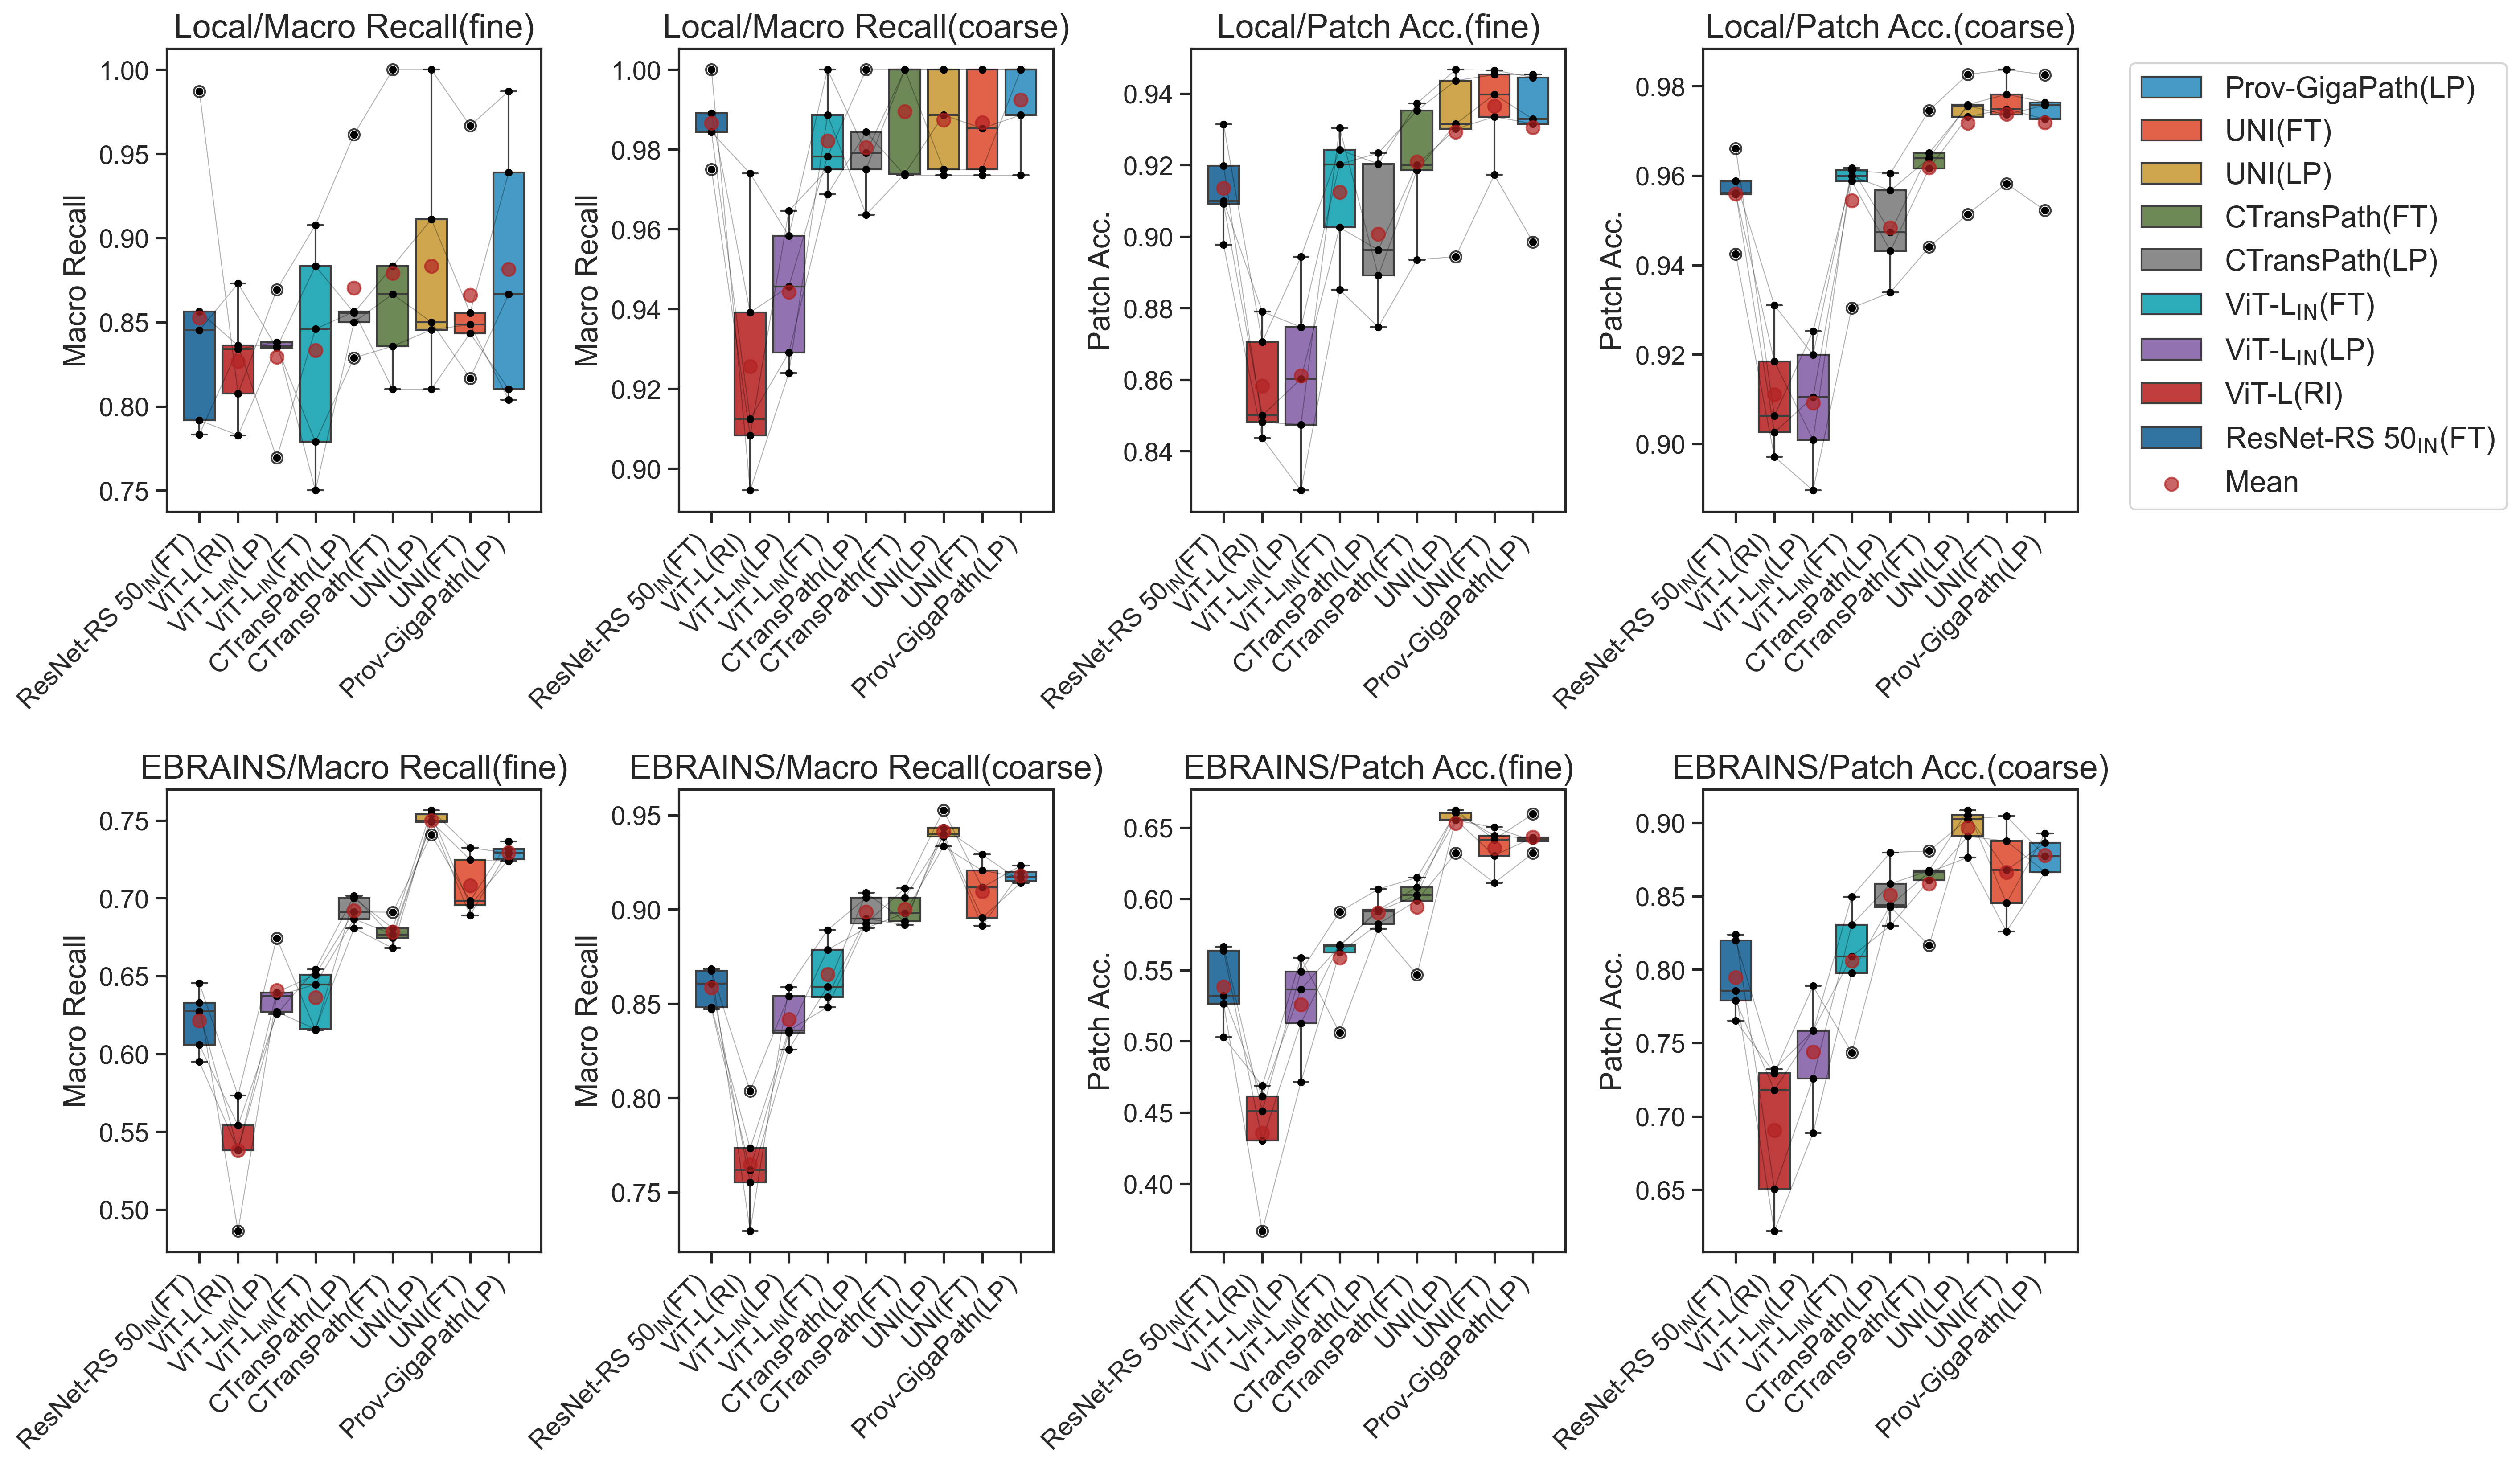

In [4]:
from datasets.ebrains import get_ebrains_df

limit = 500



fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(
    2, 5, width_ratios=[1, 1, 1, 1, 0.6],
    top = 0.95,  
    bottom = 0.05,
    right = 0.95,
    left = 0.1,
    wspace = 0.4,
    hspace = 0.6,
)


axes = [
    fig.add_subplot(gs[0]),
    fig.add_subplot(gs[1]),
    fig.add_subplot(gs[2]),
    fig.add_subplot(gs[3]),
    
    fig.add_subplot(gs[5]),
    fig.add_subplot(gs[6]),
    fig.add_subplot(gs[7]),
    fig.add_subplot(gs[8]),
]


recipes = [
    ['cv', 'fine', 'recall'],
    ['cv', 'coarse', 'recall'],
    ['cv', 'fine', 'pacc'],
    ['cv', 'coarse', 'pacc'],
    
    ['ebrains', 'fine', 'recall'],
    ['ebrains', 'coarse', 'recall'],
    ['ebrains', 'fine', 'pacc'],
    ['ebrains', 'coarse', 'pacc'],
]

for idx, ((target, grains, key), ax) in enumerate(zip(recipes, axes)):
    key_label = key_map[key]    

    df = pd.read_excel(f'out/figs/tables/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)    
    df = df[df['label'].isin(labels)]

    n_folds, n_models = 5, len(df)//5

    df_mean = df.groupby('cond')[key_label].mean().sort_values(ascending=True)
    df = df[::-1]    

    sns.boxplot(x='label', 
                hue='label', 
                y=key_label, 
                data=df, 
                palette=[color_map[label] for label in labels[::-1]], 
                ax=ax, 
                legend=True if idx == 3 else False)

    # Connect folds with lines
    for fold in range(n_folds):
        fold_data = df[df['fold'] == fold]
        ax.plot(range(n_models), fold_data[key_label], 'k-', alpha=0.3, linewidth=0.5)
    
    # Scatter individual points
    for i, label in enumerate(labels[::-1]):
        ax.scatter([i] * n_folds, df[df['label'] == label][key_label], color='black', s=10, zorder=3)
    
    mean_scatter = ax.scatter(
        labels, 
        [df[df['label'] == l][key_label].mean() for l in labels],
        color='firebrick', s=50, zorder=5, label='Mean', alpha=0.7)

    # Set ax1 properties
    target_dataset = {
        'cv': 'Local',
        'ebrains': 'EBRAINS',
    }[target]
    ax.set_xticks(range(len(labels[::-1])))
    ax.set_xticklabels(labels[::-1], rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(key_label)
    ax.set_title(f'{target_dataset}/{key_label}({grains})')

    if idx == 3:
        box_handles = ax.get_legend_handles_labels()[0][:-1][::-1]
        legend_handles = box_handles + [mean_scatter]
        legend_labels = labels + ['Mean']
        ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1.1, 1), loc='upper left')


plt.savefig('out/figs/fig2/fig2_main.png', bbox_inches='tight')
plt.show()

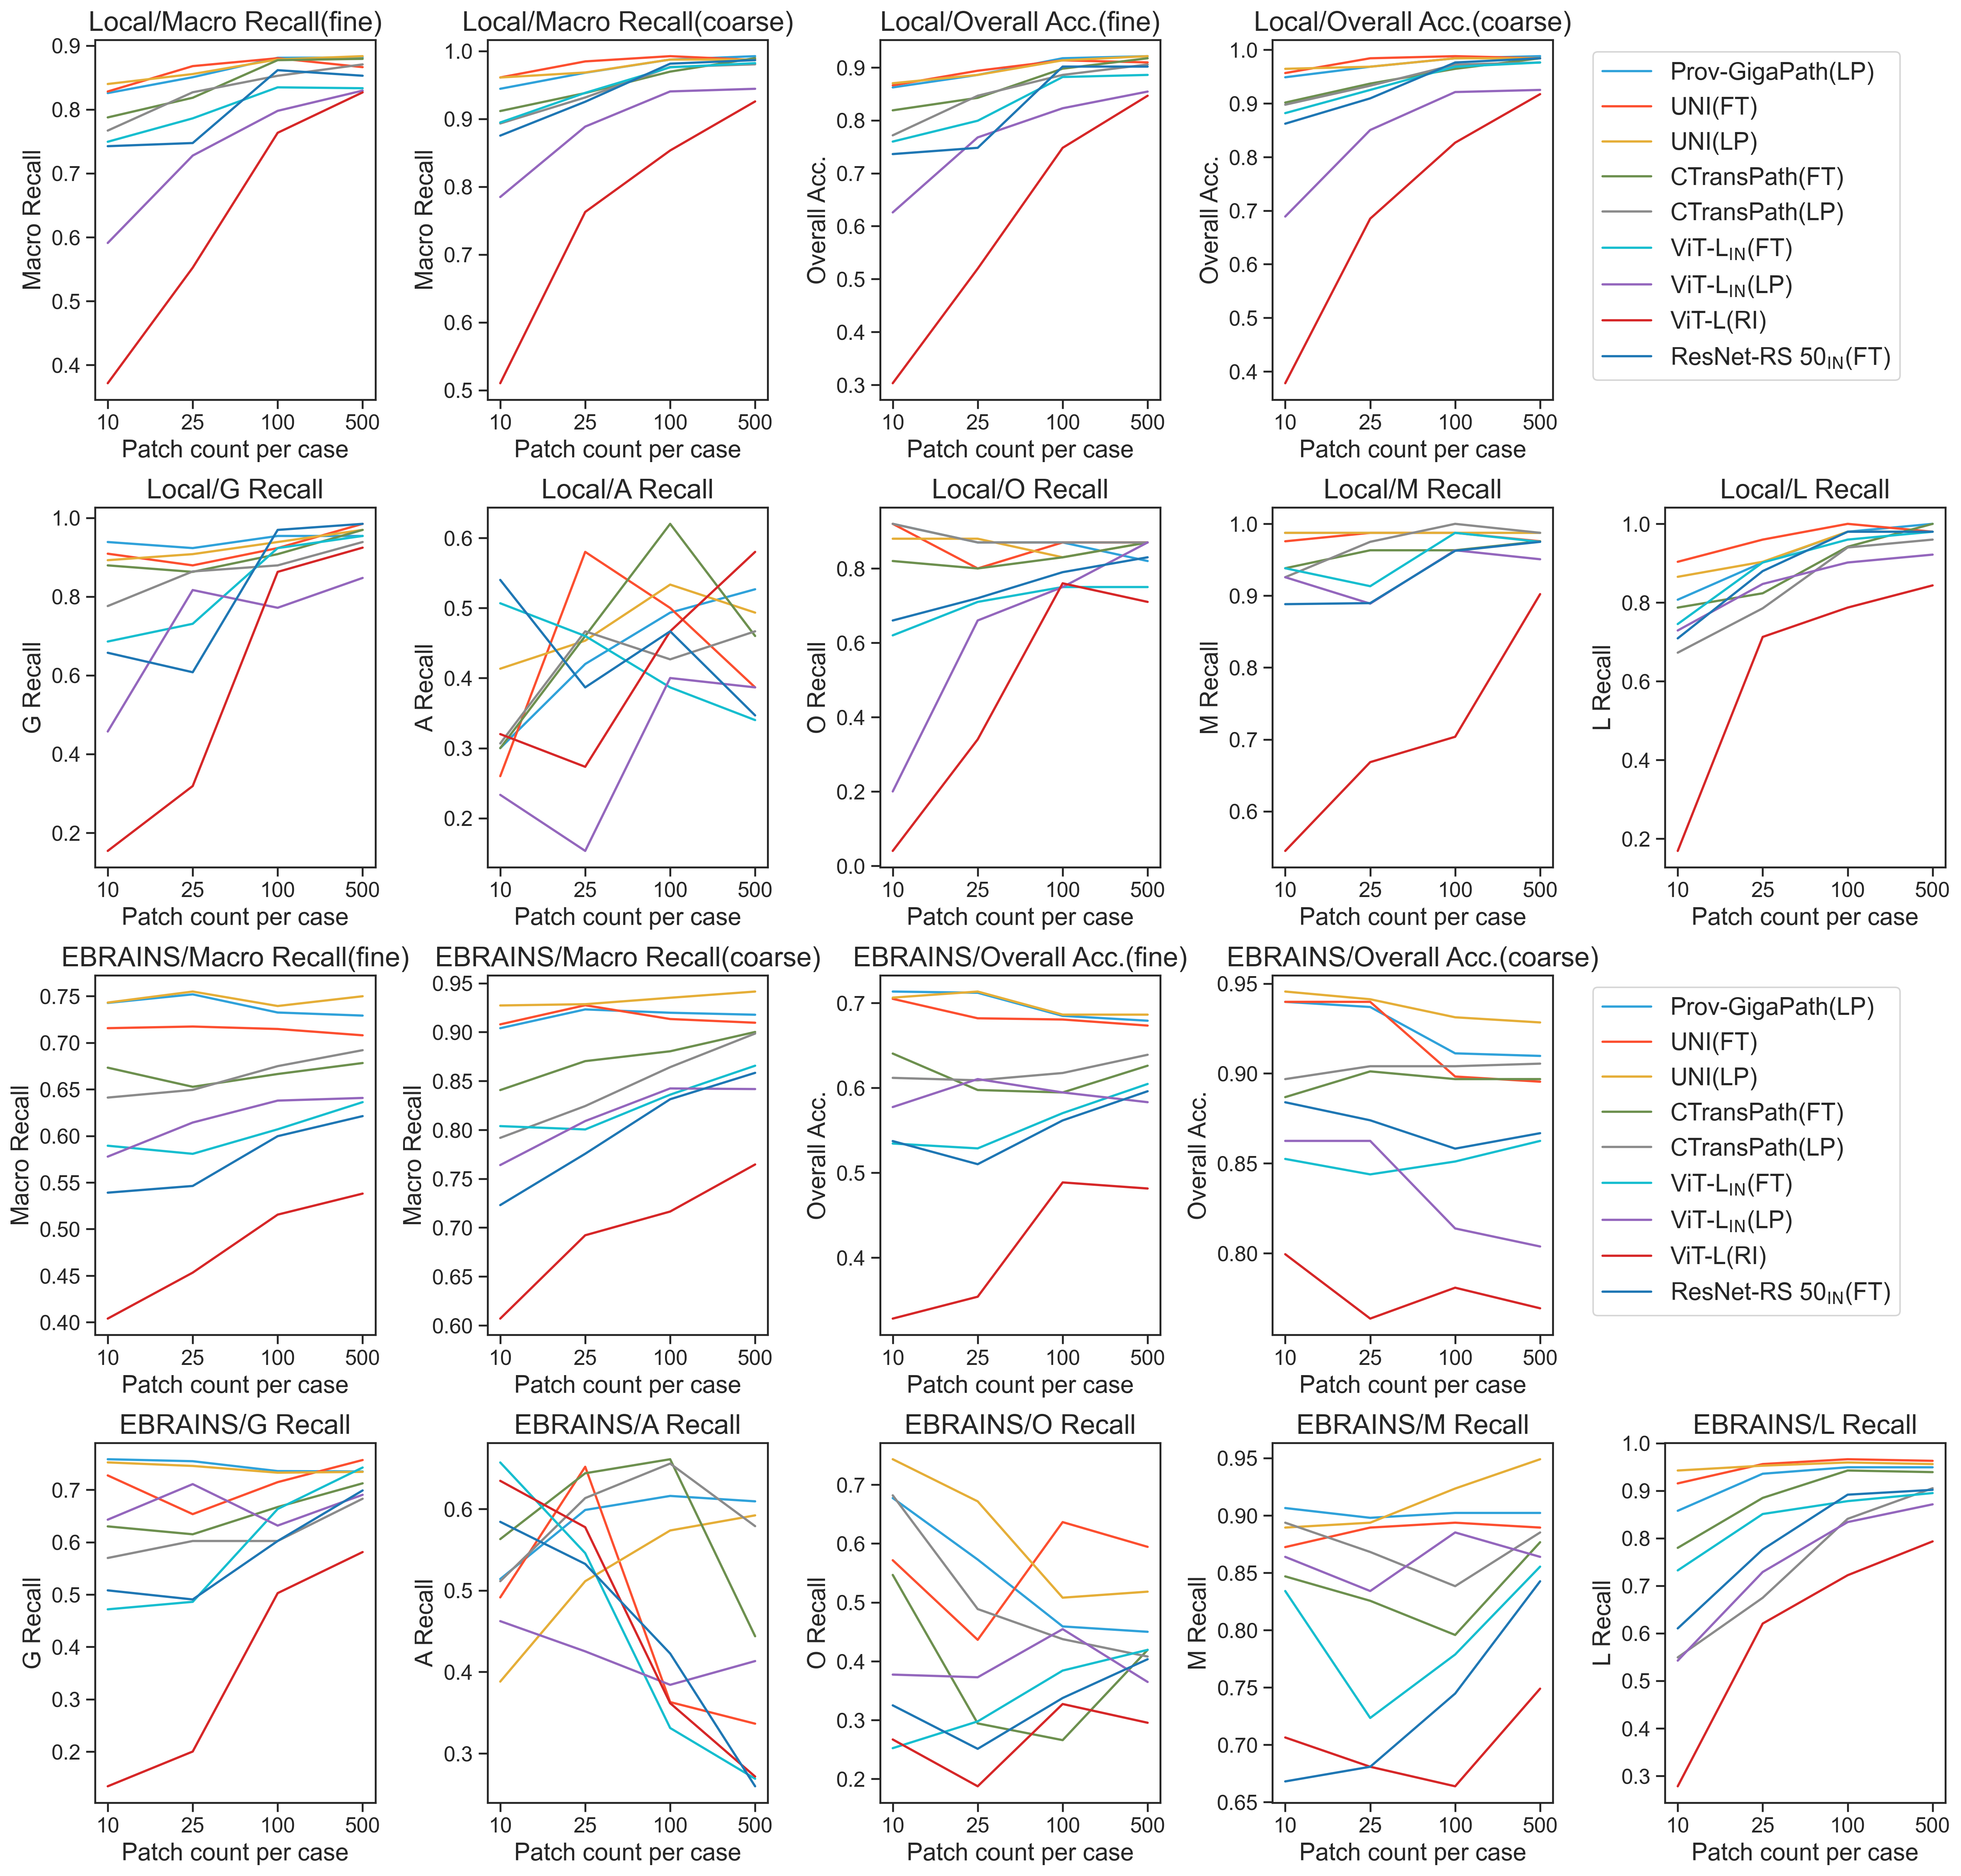

In [5]:

recipes = [
    [0, 'cv', 'fine', 'recall'],
    [1, 'cv', 'coarse', 'recall'],
    [2, 'cv', 'fine', 'oacc'],
    [3, 'cv', 'coarse', 'oacc'],
    #4

    [5, 'cv', 'fine', 'grecall'],
    [6, 'cv', 'fine', 'arecall'],
    [7, 'cv', 'fine', 'orecall'],
    [8, 'cv', 'fine', 'mrecall'],
    [9, 'cv', 'fine', 'lrecall'],
    
    [10, 'ebrains', 'fine', 'recall'],
    [11, 'ebrains', 'coarse', 'recall'],
    [12, 'ebrains', 'fine', 'oacc'],
    [13, 'ebrains', 'coarse', 'oacc'],
    #14

    [15, 'ebrains', 'fine', 'grecall'],
    [16, 'ebrains', 'fine', 'arecall'],
    [17, 'ebrains', 'fine', 'orecall'],
    [18, 'ebrains', 'fine', 'mrecall'],
    [19, 'ebrains', 'fine', 'lrecall'],
]

legend_idxs = [3, 12]

def fig_grid(name, recipes, legend_idxs):
    fig = plt.figure(figsize=(20, 18))
    gs = fig.add_gridspec(
        4, 5, width_ratios=[1, 1, 1, 1, 1],
        top = 0.95,  
        bottom = 0.05,
        right = 0.95,
        left = 0.1,
        wspace = 0.4,
        hspace = 0.3,
    )
    
    for idx, (ax_idx, target, grains, key) in enumerate(recipes):
        ax = fig.add_subplot(gs[ax_idx])
        key_label = key_map[key]
        
        limits = [10, 25, 100, 500]
        alpha = 0.05
    
        if key == 'oacc':
            vv = []
            for limit in limits:
                df = pd.read_excel(f'out/figs/tables/score_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)        
                for label in labels:
                    s = df.loc[label, 'Overall Acc.']
                    correct, total = s.split('/')
                    vv.append({
                        'value': int(correct)/int(total),
                        'limit': limit,
                        'label': label,                    
                    })
            vv = pd.DataFrame(vv)                
        else:
            vv = []
            for limit in limits:
                df = pd.read_excel(f'out/figs/tables/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)
                for label in labels:
                    scores = df[df['label']==label][key_label]
                    mean = np.mean(scores)
                    vv.append({
                        'value': mean,
                        'limit': limit,
                        'label': label,
                    })
            vv = pd.DataFrame(vv)
    
        x = np.arange(1, 1+len(limits))
    
        for i, label in enumerate(labels):
            c = color_map[label]
            t = vv[vv['label'] == label]
            ax.plot(x, t['value'], color=c, label=label)
        
        ax.set_xticks(x, limits)
        ax.set_xlabel('Patch count per case')
        ax.set_ylabel(key_label)
        target_dataset = {
            'cv': 'Local',
            'ebrains': 'EBRAINS',
        }[target]
        if is_patial_metric(key):
            title = f'{target_dataset}/{key_label}'
        else:
            title = f'{target_dataset}/{key_label}({grains})'
        ax.set_title(title)    
    
    
        if idx in legend_idxs:
            ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
    
    
    plt.savefig(f'out/figs/fig3/{name}.png', bbox_inches='tight')
    plt.show()

fig_grid('fig3_main', recipes, legend_idxs)

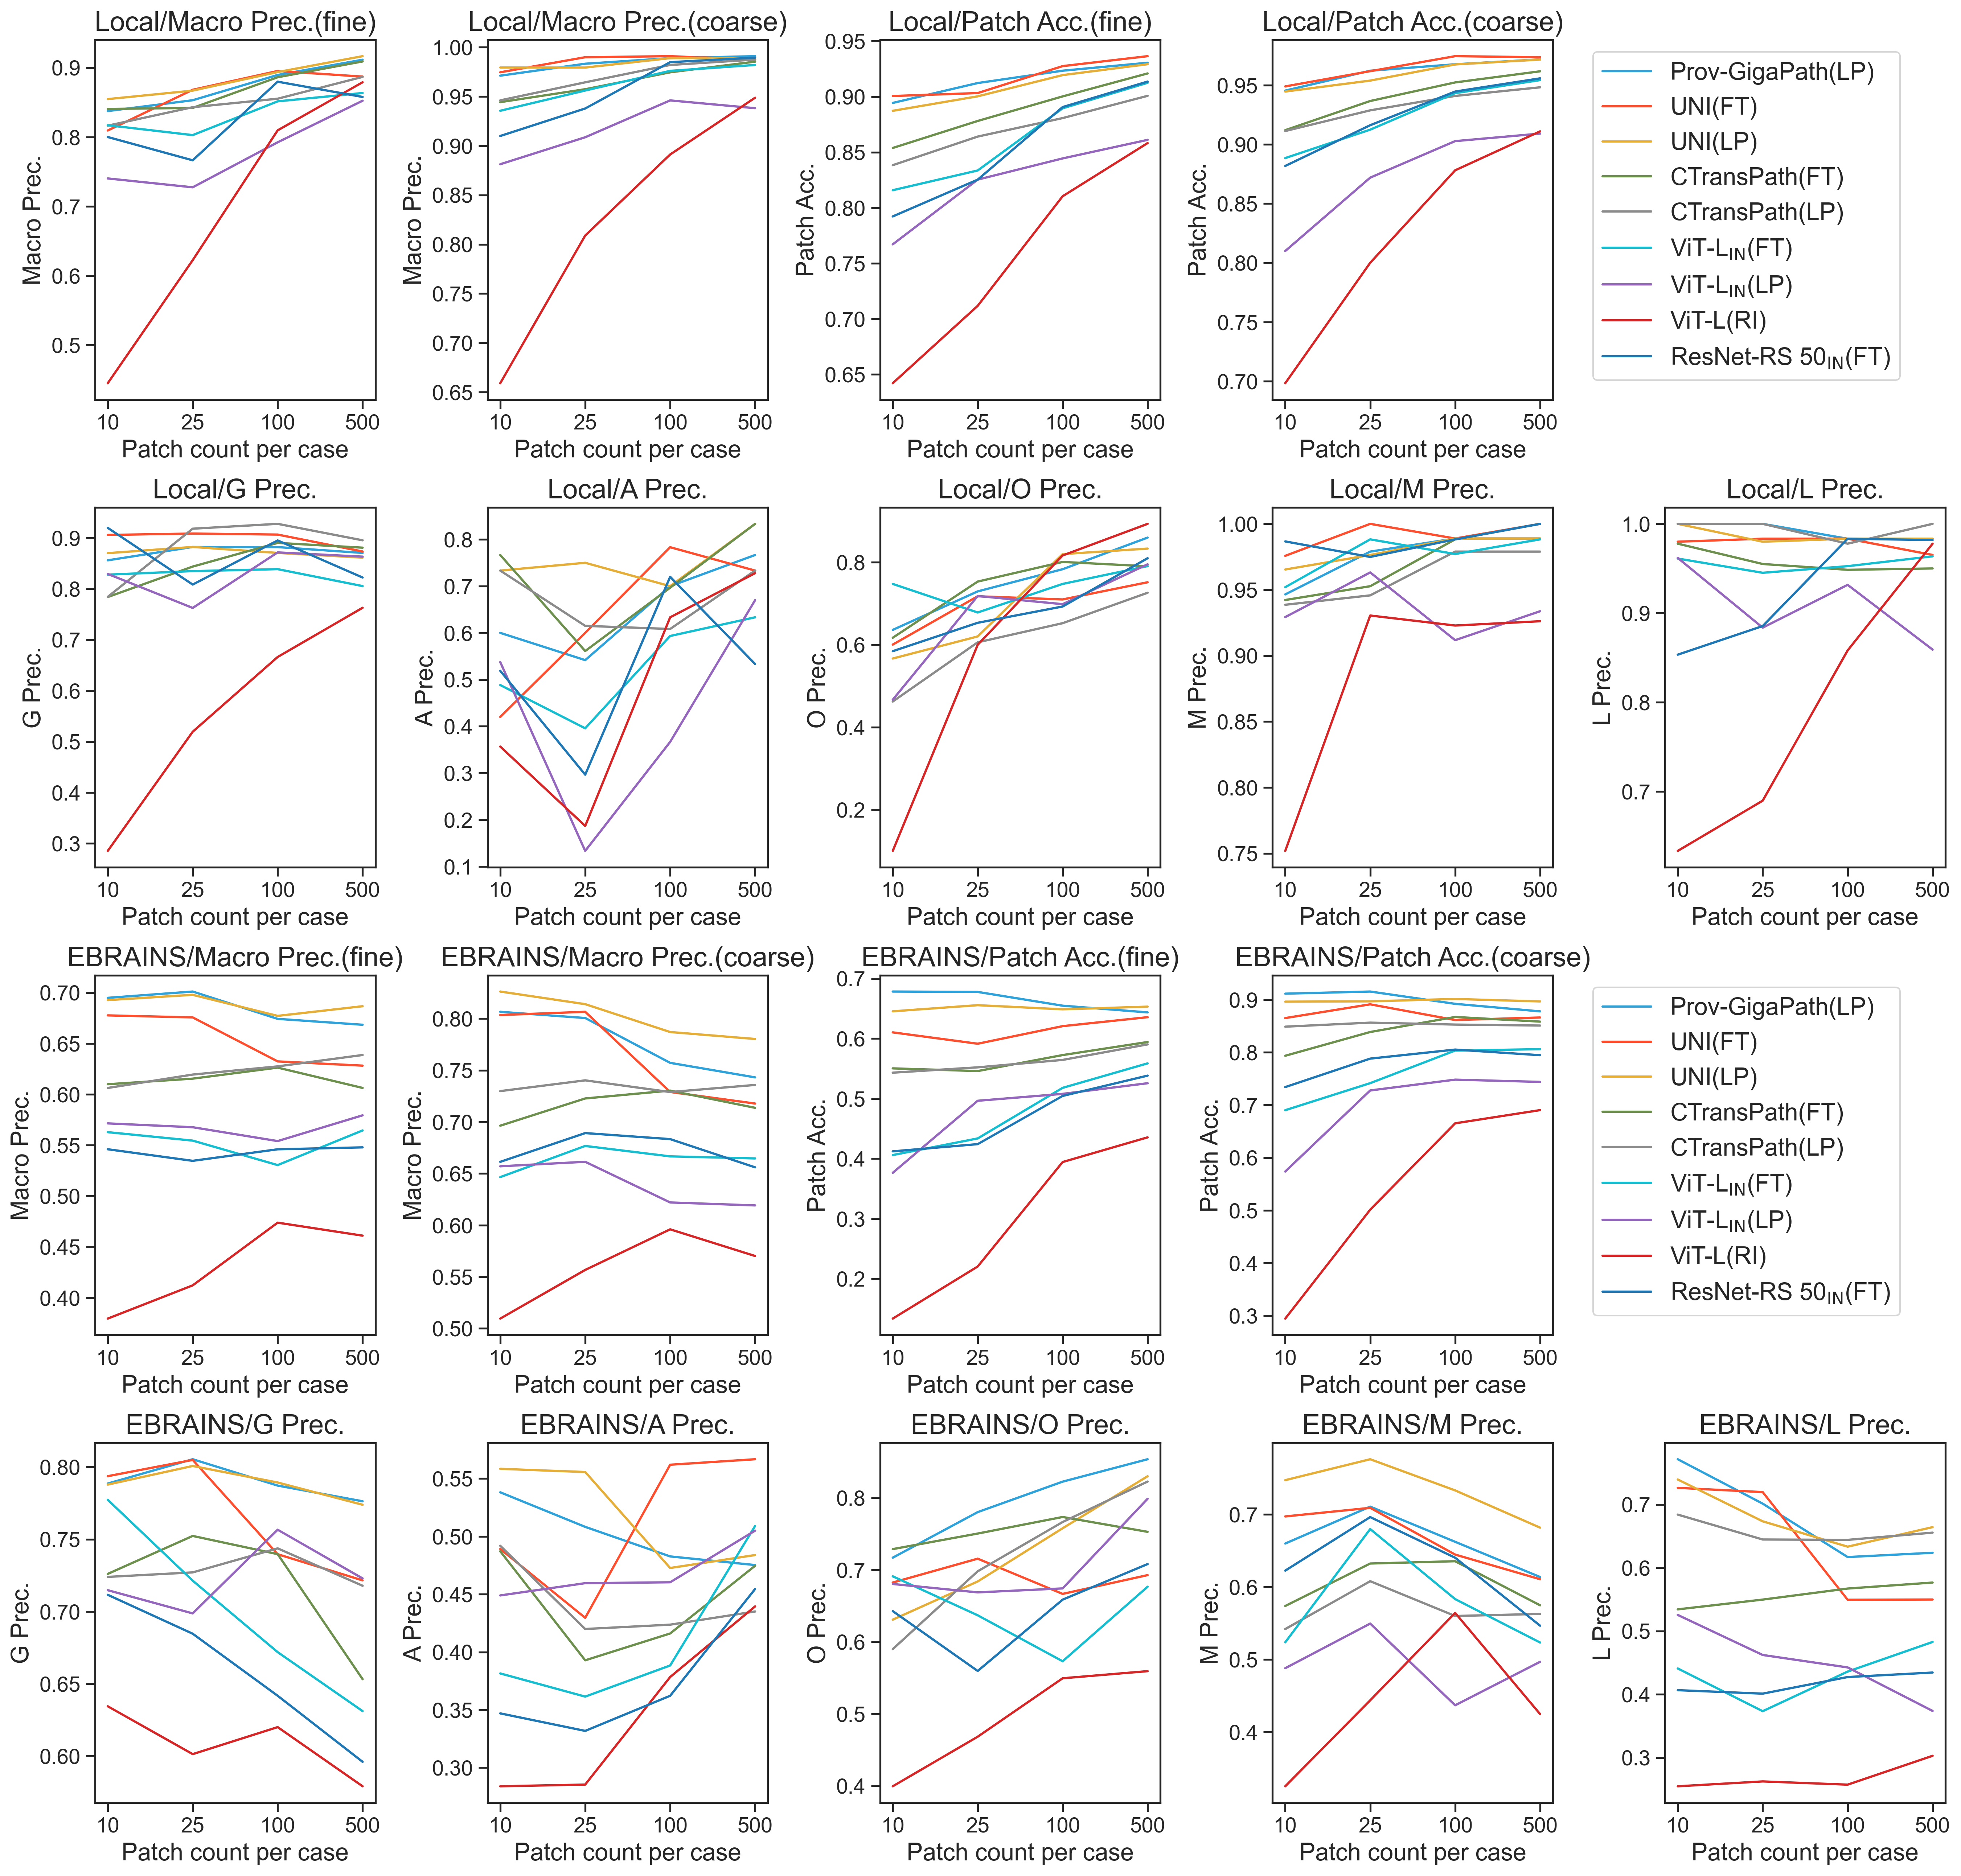

In [6]:
recipes = [
    [0, 'cv', 'fine', 'prec'],
    [1, 'cv', 'coarse', 'prec'],
    [2, 'cv', 'fine', 'pacc'],
    [3, 'cv', 'coarse', 'pacc'],
    #4

    [5, 'cv', 'fine', 'gprec'],
    [6, 'cv', 'fine', 'aprec'],
    [7, 'cv', 'fine', 'oprec'],
    [8, 'cv', 'fine', 'mprec'],
    [9, 'cv', 'fine', 'lprec'],
    
    [10, 'ebrains', 'fine', 'prec'],
    [11, 'ebrains', 'coarse', 'prec'],
    [12, 'ebrains', 'fine', 'pacc'],
    [13, 'ebrains', 'coarse', 'pacc'],
    #14

    [15, 'ebrains', 'fine', 'gprec'],
    [16, 'ebrains', 'fine', 'aprec'],
    [17, 'ebrains', 'fine', 'oprec'],
    [18, 'ebrains', 'fine', 'mprec'],
    [19, 'ebrains', 'fine', 'lprec'],
]

legend_idxs = [3, 12]



fig_grid('supfig1_main', recipes, legend_idxs)

wrote out/figs/fig2/fig2_cm.png


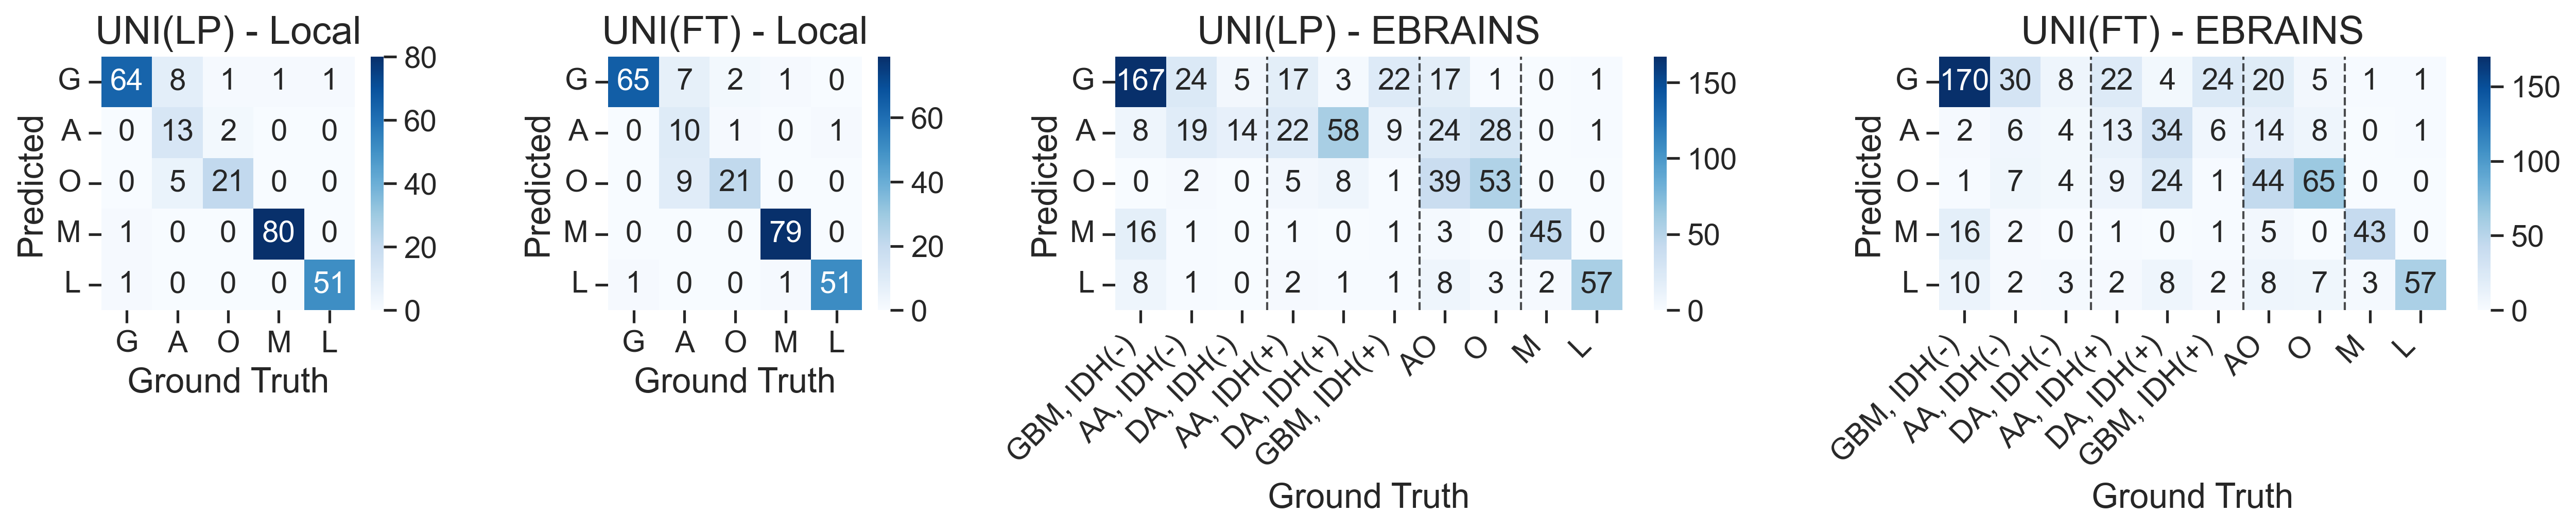

In [7]:
def draw_cm():
    fig = plt.figure(figsize=(20, 6))

    gs = fig.add_gridspec(
        1, 4, width_ratios=[1, 1, 2, 2],
        top=0.95,           # Changed from 0.01 to 0.95 to reduce top margin
        bottom=0.05,        # Changed from 0.5 to 0.05 to reduce bottom margin
        right=0.90,         # Added right margin parameter
        left=0.1,          # Added left margin parameter
        wspace=0.4,
    )

    unique_codes = list('GAOMLB')
    labels = list('GAOML')
                          
    rules = ((
        'cv', # target
        'Local', # target_label
        'frozen_uni_500', # cond
        'UNI(LP)',
        'out/compare/LMGAOB/fold5_{fold}/{cond}/test/report.xlsx', # base_path            
        fig.add_subplot(gs[0]),
    ), (
        'cv', # target
        'Local', # target_label
        'unfrozen_uni_500', # cond
        'UNI(FT)',
        'out/compare/LMGAOB/fold5_{fold}/{cond}/test/report.xlsx', # base_path            
        fig.add_subplot(gs[1]),
    ), (
        'ebrains', # target
        'EBRAINS', # target_label
        'frozen_uni_500', # cond
        'UNI(LP)', # label
        'out/compare/LMGAOB/fold5_{fold}/{cond}/ebrains.xlsx', # base_path            
        fig.add_subplot(gs[2]),
    ), (
        'ebrains', # target
        'EBRAINS', # target_label
        'unfrozen_uni_500', # cond
        'UNI(FT)', # label
        'out/compare/LMGAOB/fold5_{fold}/{cond}/ebrains.xlsx', # base_path            
        fig.add_subplot(gs[3]),
    ))
    for target, target_label, cond, label, base_path, ax in rules:        
        dfs = []
        for fold in range(5):
            # p = f'out/compare/LMGAOB/fold5_{fold}/{encoder}_{base}_{limit}/ebrains.xlsx'
            p = base_path.format(
                fold=fold,
                cond=cond,
            )
            df = pd.read_excel(p, 'cases', index_col=0)
            df['fold'] = fold
            dfs.append(df)
        df = pd.concat(dfs)

        mm = []
        if target == 'ebrains':
            df_map = get_ebrains_df()
            for name, rows in df.groupby('name'):
                preds = [rows[c].mean() for c in unique_codes]
                pred_ordered = np.array(unique_codes)[np.argsort(preds)[::-1]]
                pred = pred_ordered[1] if pred_ordered[0] == 'B' else pred_ordered[0]  
                mm.append({
                    'name': name,
                    'gt': rows.iloc[0]['label'],
                    'pred': pred,
                    'subtype': df_map.loc[name, 'subtype']
                })
        else:
            df = df[df['diag_org'] != 'B']
            for i, row in df.iterrows():
                mm.append({
                    'name': i,
                    'pred': row['pred(sum)'],
                    'gt': row['diag_org']
                })
        df = pd.DataFrame(mm)
        label = f'{label} - {target_label}'

        if target == 'ebrains':
            subtypes = [
                'GBM, IDH(-)',
                'AA, IDH(-)',
                'DA, IDH(-)',
                'AA, IDH(+)',
                'DA, IDH(+)',
                'GBM, IDH(+)',
                'AO',
                'O',
                'M',
                'L',
            ]
            cm = pd.DataFrame(0, index=labels, columns=subtypes)
            for _, row in df.iterrows():
                cm.loc[row['pred'], row['subtype']] += 1
            gt_labels = subtypes
        else:
            cm = skmetrics.confusion_matrix(df['pred'], df['gt'], labels=labels)
            gt_labels = labels

        heatmap = sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=gt_labels,
            yticklabels=labels,
            square=True,
            cbar_kws={'shrink': .5}, 
            ax=ax,
        )
        if target == 'ebrains':
            for x in [3, 6, 8]:
                ax.axvline(x=x, color='black', linestyle='--', linewidth=1, alpha=0.7)        
        
        cbar = heatmap.collections[0].colorbar
        cbar.ax.set_position([
            cbar.ax.get_position().x0,
            ax.get_position().y0,
            cbar.ax.get_position().width,
            ax.get_position().height
        ])
        
        ax.set_title(label)
        ax.set_xlabel('Ground Truth')
        ax.set_ylabel('Predicted')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        if target == 'ebrains':
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        # report = skmetrics.classification_report(df['gt'], df['pred'])
        # print(report)
    # plt.tight_layout()
    p = f'out/figs/fig2/fig2_cm.png'
    print('wrote', p)
    plt.savefig(p, bbox_inches='tight')
    plt.show()


draw_cm()